<a href="https://colab.research.google.com/github/Kabongosalomon/Word-Embedding-Investigation/blob/master/%5BTransformer%2C%20BERT%5D%20An%20empirical%20investigation%20into%20the%20properties%20of%20standard%20word%20embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/Kabongosalomon/Data-Science-With-Jeff-Sander/master/aims-za-logo.jpg" width="100" alt="cognitiveclass.ai logo" />





# IMdb Sentiment Analysis Task

## Importing usefull packages 

In [1]:
import torch

import tensorflow as tf
!pip install transformers
import transformers as ppb

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')

import numpy as np

import matplotlib.pyplot as plt

import os

import numpy as np

import string

!pip install ipdb
import ipdb # deb

# from gensim.models.keyedvectors import KeyedVectors

# Spliting data
from sklearn.model_selection import train_test_split

from sklearn import metrics # For RUC

from nltk.stem import PorterStemmer

import pandas as pd
import re
import seaborn as sns

# from google.colab import files

from IPython import display

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# link = "https://drive.google.com/file/d/1smGRs2g2HoI6VSvonoZmWKzXOP6uPUaW/view?usp=sharing"

# _, id_t = link.split('d/')

# id = id_t.split('/')[0]
# print (id) # Verify that you have everything after '='

# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once per notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)


# file_id = id
# downloaded = drive.CreateFile({'id':file_id})
# downloaded.FetchMetadata(fetch_all=True)
# downloaded.GetContentFile(downloaded.metadata['title'])

In [3]:
# !ls

In [4]:
# !unzip -qq aclImdb.zip

In [5]:
# !ls

In [19]:
class LossPrettifier(object):
    
    STYLE = {
        'green' : '\033[32m',
        'red'   : '\033[91m', 
        'bold'  : '\033[1m', 
    }
    STYLE_END = '\033[0m'
    
    def __init__(self, show_percentage=False):
        
        self.show_percentage = show_percentage
        self.color_up = 'green'
        self.color_down = 'red'
        self.loss_terms = {}
    
    def __call__(self, epoch=None, **kwargs):
        
        if epoch is not None:
            print_string = f'Epoch {epoch: 5d} '
        else:
            print_string = ''

        for key, value in kwargs.items():
            
            pre_value = self.loss_terms.get(key, value)
            
            if value > pre_value:
                indicator  = '▲'
                show_color = self.STYLE[self.color_up]
            elif value == pre_value:
                indicator  = ''
                show_color = ''
            else:
                indicator  = '▼'
                show_color = self.STYLE[self.color_down]
            
            if self.show_percentage:
                show_value = 0 if pre_value == 0 \
                             else (value - pre_value) / float(pre_value)
                key_string = f'| {key}: {show_color}{value:3.4f}({show_value:+3.4%}) {indicator}'
            else: 
                key_string = f'| {key}: {show_color}{value:.4f} {indicator}'
            
            # Trim some long outputs
            key_string_part = key_string[:32]
            print_string += key_string_part+f'{self.STYLE_END}\t'
            
            self.loss_terms[key] = value
            
        print(print_string)
reporter = LossPrettifier(show_percentage=True)

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

## Model #2: Train/Test Split
Let's now split our datset into a training set and testing set (even though we're using 2,000 sentences from the SST2 training set).

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.

In [13]:
!pip install transformers

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [15]:
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [16]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
len(tokenizer.vocab)


30522

In [18]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [19]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


Another thing we need to handle is that the model was trained on sequences with a defined maximum length - it does not know how to handle sequences longer than it has been trained on. We can get the maximum length of these input sizes by checking the max_model_input_sizes for the version of the transformer we want to use. In this case, it is 512 tokens.

In [20]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

# max_input_length = 250

print(max_input_length)

512


Previously we have used the spaCy tokenizer to tokenize our examples. However we now need to define a function that we will pass to our TEXT field that will handle all the tokenization for us. It will also cut down the number of tokens to a maximum length. Note that our maximum length is 2 less than the actual maximum length. This is because we need to append two tokens to each sequence, one to the start and one to the end.

In [21]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens


Now we define our fields. The transformer expects the batch dimension to be first, so we set batch_first = True. As we already have the vocabulary for our text, provided by the transformer we set use_vocab = False to tell torchtext that we'll be handling the vocabulary side of things. We pass our tokenize_and_cut function as the tokenizer. The preprocessing argument is a function that takes in the example after it has been tokenized, this is where we will convert the tokens to their indexes. Finally, we define the special tokens - making note that we are defining them to be their index value and not their string value, i.e. 100 instead of [UNK] This is because the sequences will already be converted into indexes.

We define the label field as before.

In [22]:
from torchtext import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [23]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [24]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


We can check an example and ensure that the text has already been numericalized.

In [25]:
print(vars(train_data.examples[6]))

{'text': [2178, 2329, 5988, 5210, 4400, 2099, 1012, 2613, 13044, 2006, 3749, 2182, 2320, 2153, 1012, 1045, 3685, 3305, 1006, 1998, 1045, 2572, 2329, 1007, 2339, 2023, 2058, 1996, 2327, 1010, 14314, 14652, 2001, 2412, 2081, 1012, 2809, 2086, 2928, 2017, 1010, 2013, 2043, 1996, 2117, 2088, 2162, 2018, 2941, 3092, 999, 2060, 7615, 2121, 1005, 1055, 2182, 2031, 10783, 2006, 1996, 9260, 1998, 6835, 25180, 3238, 2224, 1997, 8756, 8333, 1012, 2023, 2003, 5186, 9996, 5159, 1012, 1996, 8756, 8333, 2003, 1999, 14531, 1012, 2944, 2948, 7370, 2013, 14666, 1999, 1996, 1005, 2895, 5019, 1005, 2066, 2061, 2116, 2336, 1005, 1055, 20497, 2015, 1999, 1996, 3612, 1012, 1996, 5156, 4949, 2282, 10071, 11660, 1996, 3185, 2000, 2191, 2149, 10743, 4567, 2046, 1996, 2878, 9933, 2724, 1012, 17323, 2442, 2031, 2010, 5409, 3772, 2836, 2412, 1012, 1996, 16880, 2067, 4530, 3899, 2954, 5019, 2024, 4756, 3085, 1012, 13835, 8501, 2015, 2149, 2035, 2000, 2331, 1999, 1996, 4949, 2282, 2181, 1012, 19413, 2989, 2081, 2116

In [26]:
len(vars(train_data.examples[900])['text'])

143

We can use the convert_ids_to_tokens to transform these indexes back into readable tokens.

In [27]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[6])['text'])

print(tokens)

['another', 'british', 'cinema', 'flag', 'wave', '##r', '.', 'real', 'garbage', 'on', 'offer', 'here', 'once', 'again', '.', 'i', 'cannot', 'understand', '(', 'and', 'i', 'am', 'british', ')', 'why', 'this', 'over', 'the', 'top', ',', 'patriotic', 'nonsense', 'was', 'ever', 'made', '.', 'eight', 'years', 'mark', 'you', ',', 'from', 'when', 'the', 'second', 'world', 'war', 'had', 'actually', 'ended', '!', 'other', 'comment', '##er', "'", 's', 'here', 'have', 'remarked', 'on', 'the', 'editing', 'and', 'apparent', 'seam', '##less', 'use', 'of', 'archive', 'footage', '.', 'this', 'is', 'extremely', 'poorly', 'observed', '.', 'the', 'archive', 'footage', 'is', 'in', 'abundance', '.', 'model', 'aircraft', 'swing', 'from', 'wires', 'in', 'the', "'", 'action', 'scenes', "'", 'like', 'so', 'many', 'children', "'", 's', 'kite', '##s', 'in', 'the', 'wind', '.', 'the', 'usual', 'map', 'room', 'sequences', 'tattoo', 'the', 'movie', 'to', 'make', 'us', 'supposedly', 'drawn', 'into', 'the', 'whole', 

Although we've handled the vocabulary for the text, we still need to build the vocabulary for the labels.

In [28]:
LABEL.build_vocab(train_data)

In [29]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [30]:
next(train_iterator.__iter__())


[torchtext.data.batch.Batch of size 128]
	[.text]:[torch.cuda.LongTensor of size 128x512 (GPU 0)]
	[.label]:[torch.cuda.FloatTensor of size 128 (GPU 0)]

In [31]:
next(train_iterator.__iter__()).text.shape

torch.Size([128, 512])

In [32]:
next(valid_iterator.__iter__()).text.shape

torch.Size([128, 61])

In [33]:
next(test_iterator.__iter__()).text.shape

torch.Size([128, 49])

In [34]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

In [35]:
import torch.nn as nn

class BERT_FNN_Sentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 number_classes):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.fc = nn.Linear(393216, number_classes) # got this error from pytorch error :)
                
        # self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0] 
        # ipdb.set_trace()  
        #embedded = [batch size, sent len, emb dim]
        
        batch_size = embedded.shape[0]
        
        # x = self.linear(x.view(batch_size, -1))

        output = self.fc(embedded.view(batch_size, -1))
        
        
        return output

In [36]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [37]:
# HIDDEN_DIM = 256
# OUTPUT_DIM = 1

# model = BERT_FNN_Sentiment(bert,
#                          HIDDEN_DIM,
#                          OUTPUT_DIM)

In [41]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)


We can check how many parameters the model has. Our standard models have under 5M, but this one has 112M! Luckily, 110M of these parameters are from the transformer and we will not be training those.

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In order to freeze paramers (not train them) we need to set their requires_grad attribute to False. To do this, we simply loop through all of the named_parameters in our model and if they're a part of the bert transformer model, we set requires_grad = False.

In [43]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [44]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


We can double check the names of the trainable parameters, ensuring they make sense. As we can see, they are all the parameters of tthe linear layer (out).

In [45]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


In [46]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [47]:
criterion = nn.BCEWithLogitsLoss()

In [48]:
model = model.to(device)
criterion = criterion.to(device)

In [49]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [50]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [51]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [53]:
N_EPOCHS = 10

best_valid_loss = float('inf')

total_loss_train = []
total_acc_train = []


total_loss_valid = []
total_acc_valid = []


for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    total_loss_train.append(train_loss)
    total_acc_train.append(train_acc)
    
    total_loss_valid.append(valid_loss)
    total_acc_valid.append(valid_acc)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 6m 42s
	Train Loss: 0.450 | Train Acc: 78.80%
	 Val. Loss: 0.293 |  Val. Acc: 87.94%
Epoch: 02 | Epoch Time: 6m 42s
	Train Loss: 0.279 | Train Acc: 88.74%
	 Val. Loss: 0.228 |  Val. Acc: 90.82%
Epoch: 03 | Epoch Time: 6m 41s
	Train Loss: 0.234 | Train Acc: 90.81%
	 Val. Loss: 0.208 |  Val. Acc: 91.77%
Epoch: 04 | Epoch Time: 6m 41s
	Train Loss: 0.212 | Train Acc: 91.64%
	 Val. Loss: 0.215 |  Val. Acc: 91.55%
Epoch: 05 | Epoch Time: 6m 42s
	Train Loss: 0.181 | Train Acc: 93.23%
	 Val. Loss: 0.228 |  Val. Acc: 91.32%
Epoch: 06 | Epoch Time: 6m 42s
	Train Loss: 0.163 | Train Acc: 93.79%
	 Val. Loss: 0.219 |  Val. Acc: 91.51%
Epoch: 07 | Epoch Time: 6m 42s
	Train Loss: 0.124 | Train Acc: 95.49%
	 Val. Loss: 0.274 |  Val. Acc: 90.40%
Epoch: 08 | Epoch Time: 6m 42s
	Train Loss: 0.114 | Train Acc: 95.78%
	 Val. Loss: 0.262 |  Val. Acc: 91.13%
Epoch: 09 | Epoch Time: 6m 42s
	Train Loss: 0.084 | Train Acc: 97.02%
	 Val. Loss: 0.269 |  Val. Acc: 91.83%
Epoch: 10 | Epoch T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


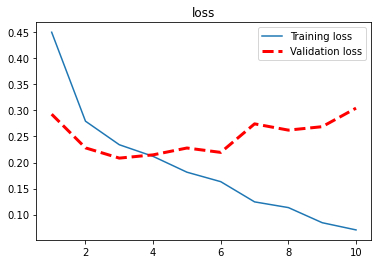

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


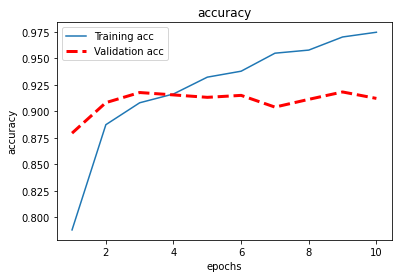

In [54]:
acc = total_acc_train
val_acc = total_acc_valid
loss = total_loss_train
val_loss = total_loss_valid

epochs = range(1, N_EPOCHS + 1)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss', linewidth=3)
plt.title('loss')
plt.legend()
plt.savefig("Training and Validation loss.eps", format='eps', dpi=1200)

plt.show()

plt.figure()
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc,'r--', label='Validation acc', linewidth=3)
plt.title('accuracy')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig("Training and validation accuracy.eps", format='eps', dpi=1200)
plt.show()

We'll load up the parameters that gave us the best validation loss and try these on the test set - which gives us our best results so far!

In [56]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.200 | Test Acc: 92.14%


## Inference
We'll then use the model to test the sentiment of some sequences. We tokenize the input sequence, trim it down to the maximum length, add the special tokens to either side, convert it to a tensor, add a fake batch dimension and then pass it through our model.

In [58]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [59]:
predict_sentiment(model, tokenizer, "This film is terrible")


0.018738683313131332

In [60]:
predict_sentiment(model, tokenizer, "This film is great")


0.9396399259567261

---
<h1>About the Authors:</h1> 

<a href="https://skabongo.github.io/">Salomon Kabongo</a>, Master degree student at <a href="https://aims.ac.za/">the African Master in Machine Intelligence (AMMI, Ghana)</a> his research focused on the use machine learning technique in the field of Natural Language Processing, learn more about him [here](https://skabongo.github.io/) or [twitter](https://twitter.com/SalomonKabongo1).

**References :** 
- <a href="https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/"> How to Develop a Deep Learning Bag-of-Words Model for Predicting Movie Review Sentiment</a>, <a href="https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb"> Github repo pytorch-sentiment-analysis</a>
- https://github.com/bentrevett/pytorch-sentiment-analysis


Copyright &copy; 2020. This notebook and its source code are released under the terms of the <a href="https://www.apache.org/licenses/LICENSE-2.0">Apache License 2.0</a>.